In [ ]:
#!pip install scikit-learn
#!pip install transformers
#!pip install datasets
#!pip install accelerate
#!pip install evaluate
#!pip install nltk
#!pip install polars
#!pip install shap
#!pip install matplotlib
#!pip install gdown

In [39]:
import numpy as np
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import shap
import polars as pl
import re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE
from tqdm.auto import tqdm
import torch
import math
import gdown
import statistics
from datasets import load_dataset
import pickle

In [2]:
# run accelerate config

Keep running until True

In [5]:
np.random.seed(101)
shap.initjs()
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /users/ujan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

##### Load sample sports and political data

In [ ]:
#sports_id = "1Xc6VXdG8cloh8tdxAaboQewkilgvWxub"
#politics_id = "1EVu3LrPIsHTrJhl8oICvxO8CxoeYbSbo"
#sports_output = 'sports_sample.csv'
#politics_output = 'politics_sample.csv'
#gdown.download(id=sports_id, output=sports_output, quiet=False)
#print('sports sample downloaded')
#gdown.download(id=politics_id, output=politics_output, quiet=False)
#print('politics sample downloaded')

#sports_df = pl.read_csv('sports_sample.csv')
#politics_df = pl.read_csv('politics_sample.csv')

In [6]:
sports_df = pl.read_csv('~/sports-language-in-politics/data/processed/sports_sample.csv')
politics_df = pl.read_csv('~/sports-language-in-politics/data/processed/politics_sample.csv')

##### Extract sports and political comments and clean. Generate boolean labels

In [7]:
sports_comments = [re.sub(r"[^a-zA-Z0-9]+", ' ', comment).lower() for comment in sports_df['body'].to_list()]
political_comments = [re.sub(r"[^a-zA-Z0-9]+", ' ', comment).lower() for comment in politics_df['body'].to_list()]

Filter short comments

In [8]:
thresh = 20
sports_comments_long = []
political_comments_long = []

s_lens = [len(s.split()) for s in sports_comments]
p_lens = [len(c.split()) for c in political_comments]

for i in range(len(sports_comments)):
    if s_lens[i] >= thresh:
        sports_comments_long.append(sports_comments[i])
for i in range(len(political_comments)):
    if p_lens[i] >= thresh:
        political_comments_long.append(political_comments[i])

Take with a sample to build vocab

In [9]:
classifier_sample_size = 50000
sports_comments = sports_comments_long[:classifier_sample_size]
political_comments = political_comments_long[:classifier_sample_size]

# labels
sports_y = np.ones(len(sports_comments), dtype=bool)
politics_y = np.zeros(len(political_comments), dtype=bool)

##### Concatenate, shuffle and split into train and test

In [10]:
sports_comments.extend(political_comments)
y = np.concatenate((sports_y, politics_y))

corpus_train, corpus_test, y_train, y_test = train_test_split(
    sports_comments, y, test_size=0.2, random_state=7
)

print('train data size : {}'.format(len(corpus_train)))
print('test data size : {}'.format(len(corpus_test)))

train data size : 80000
test data size : 20000


##### Fit a linear logistic regression model

In [11]:
vectorizer = TfidfVectorizer(min_df=10)
X_train = vectorizer.fit_transform(
    corpus_train
).toarray()  # sparse also works but Explanation slicing is not yet supported
X_test = vectorizer.transform(corpus_test).toarray()

model = sklearn.linear_model.LogisticRegression(penalty="l2", C=0.1)
model.fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

       False       0.89      0.91      0.90      9976
        True       0.90      0.88      0.89     10024

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000



Save model

In [38]:
with open('/users/Ujan/sports-language-in-politics/models/classifier_model.pkl','wb') as f:
    pickle.dump(model, f)

NameError: name 'pickle' is not defined

Load model

In [ ]:
with open('/users/Ujan/sports-language-in-politics/models/classifier_model.pkl', 'rb') as f:
    model = pickle.load(f)

##### Results for different sample sizes

Do not run 

sample size : 20000

In [ ]:
              precision    recall  f1-score   support

       False       0.83      0.76      0.79      4014
        True       0.78      0.84      0.81      3986

    accuracy                           0.80      8000
   macro avg       0.80      0.80      0.80      8000
weighted avg       0.80      0.80      0.80      8000

sample size : 50000 (being used)

In [ ]:
              precision    recall  f1-score   support

       False       0.83      0.78      0.80      9976
        True       0.79      0.84      0.82     10024

    accuracy                           0.81     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.81      0.81      0.81     20000

sample size : 100000

In [ ]:
             precision    recall  f1-score   support

       False       0.85      0.79      0.81     20021
        True       0.80      0.86      0.83     19979

    accuracy                           0.82     40000
   macro avg       0.82      0.82      0.82     40000
weighted avg       0.82      0.82      0.82     40000

##### Explain the linear model

In [12]:
explainer = shap.Explainer(
    model, X_train, feature_names=vectorizer.get_feature_names_out()
)
shap_values = explainer(X_test)

##### Summarize the effect of all the features

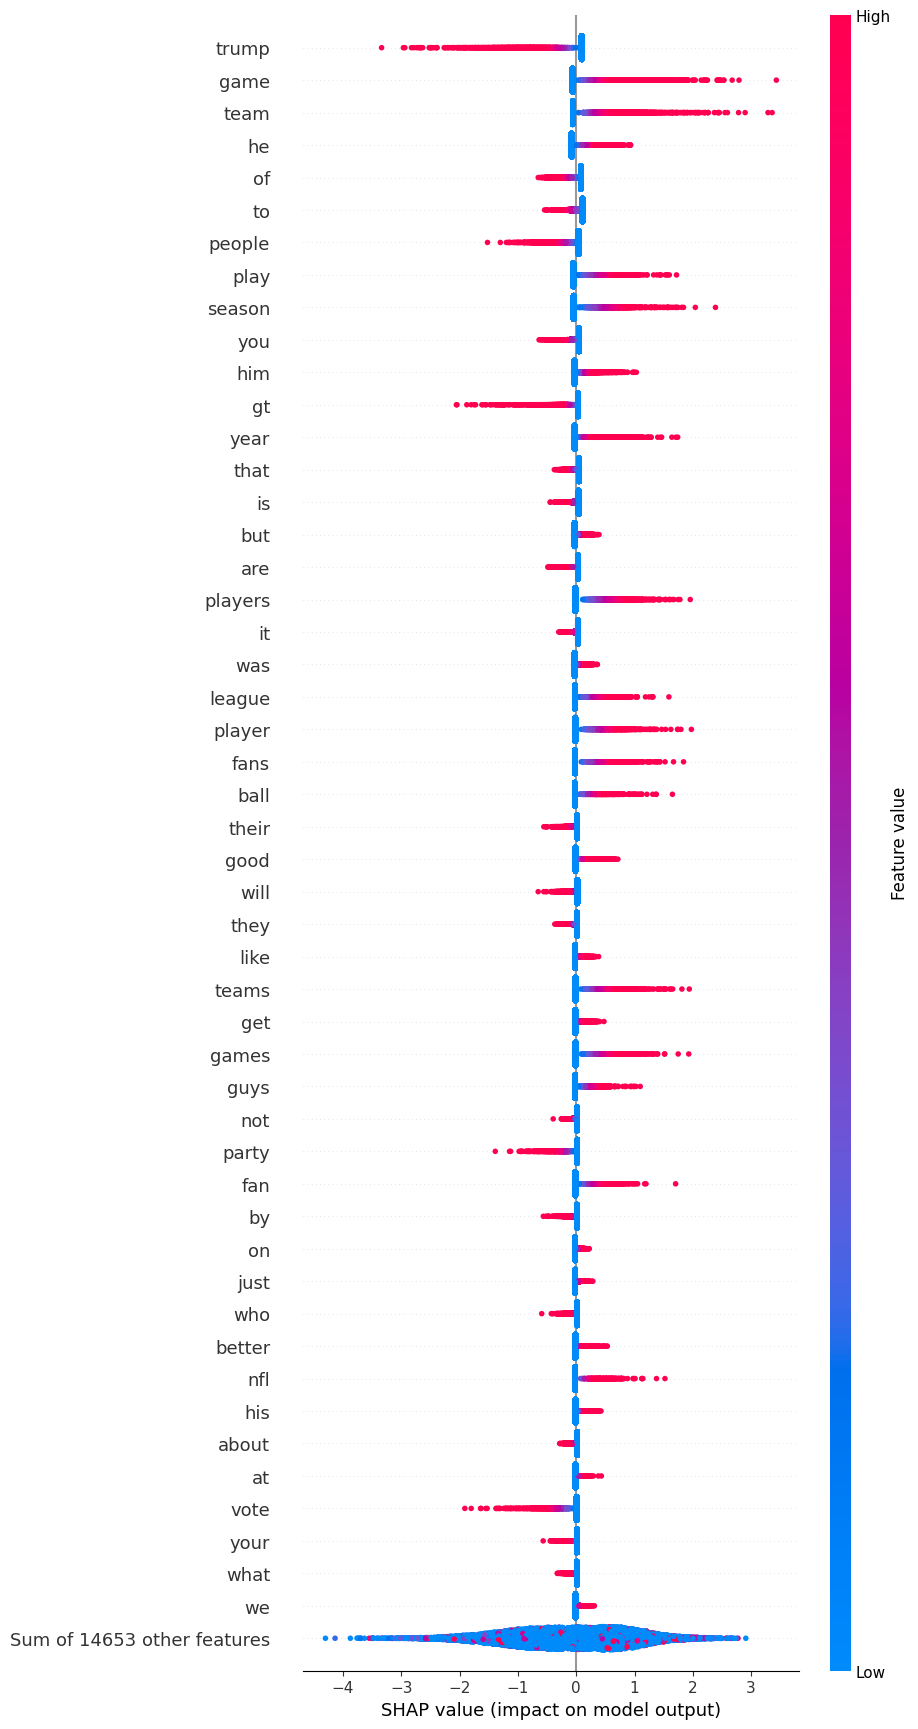

In [13]:
shap.plots.beeswarm(shap_values, max_display=50)

##### Shapley values tell us how each feature affects the prediction of a data point.

We could look at the average contribution of a feature across data points in terms of impact on model output. However we are interested in features that strongly predict sports or political content. Therefore it perhaps makes sense to look at maximum and minimum values

In [14]:
min_values = np.min(shap_values.values, axis=0)
max_values = np.max(shap_values.values, axis=0)

##### Get feature names from the Tfidf vectorizer

In [15]:
feature_names = vectorizer.get_feature_names_out()

##### Fix a threshold to select features

In [16]:
thresh = 0.35

sports_words = {}
political_words = {}

for f in range(len(feature_names)):
    name = feature_names[f]
    if abs(min_values[f]) + thresh < abs(max_values[f]):
        sports_words[name] = max_values[f]
    elif abs(min_values[f]) > abs(max_values[f]) + thresh:
        political_words[name] = min_values[f]

print('sports words : {}'.format(len(sports_words)))
print('political words : {}'.format(len(political_words)))

sports words : 188
political words : 200


In [17]:
sports_words

{'1st': 0.4159680542921237,
 '2nd': 0.36399399375686264,
 '3rd': 0.46469617237161553,
 'at': 0.431255114240377,
 'back': 0.3575458472859139,
 'ball': 1.6506117918355079,
 'baseball': 0.7523818486623588,
 'basketball': 0.862236785323348,
 'beat': 0.3828366227206318,
 'bench': 0.5248548380327822,
 'best': 0.7956272566870619,
 'better': 0.5335953215181194,
 'big': 0.5114647555745655,
 'boston': 0.46095638760361096,
 'bowl': 0.4503462820284602,
 'brady': 0.578908441313489,
 'browns': 0.5027366699908429,
 'bucks': 0.3979474963801928,
 'but': 0.3917907188612069,
 'cap': 0.8536605275658732,
 'career': 0.4381436143714864,
 'cavs': 0.4165191126163719,
 'celtics': 0.356708127057546,
 'championship': 0.36844610669806777,
 'chelsea': 0.39454949832783165,
 'city': 0.6338595380498063,
 'cleveland': 0.3754564848813394,
 'club': 0.9233355387758945,
 'clubs': 0.5115415887547187,
 'coach': 1.093505716478604,
 'coaches': 0.5655433706354074,
 'coaching': 0.3805105637795863,
 'contract': 0.7966397867840079

##### Filter sports vocab

In [18]:
# word : max/min shap_value
sports_vocab = {}

# filter stop words
cachedStopWords = stopwords.words("english")
for word, value in sports_words.items():
    if word not in cachedStopWords:
        sports_vocab[word] = value

print('sports words : {}'.format(len(sports_vocab)))

sports words : 182


##### ngram : Use this as a sports vocab

Tokenize political comments

In [19]:
tokenized_pol_comments = [list(map(str.lower, word_tokenize(sent))) for sent in political_comments_long]

Take shorter sample since MLE takes too long

In [20]:
thresh = 50000

tokenized_pol_comments = tokenized_pol_comments[:thresh]

In [21]:
# preprocess the tokenized text for 3-grams language modelling
n = 3
train_data, padded_sents = padded_everygram_pipeline(n, tokenized_pol_comments)

Train n gram model

In [22]:
# train a 3-grams model, previously we set n=3
pol_model = MLE(n)
pol_model.fit(train_data, padded_sents)

Vocab size

In [24]:
len(pol_model.vocab)

59607

Train another ngram model on wikitext data

In [25]:
wikitext = load_dataset('wikitext', 'wikitext-103-v1')
# same sample size
wiki = wikitext['train']['text'][:thresh]
tokenized_wiki = [list(map(str.lower, word_tokenize(sent))) for sent in wiki]

In [28]:
# Preprocess the tokenized text for 3-grams language modelling
n = 3
train_data, padded_sents = padded_everygram_pipeline(n, tokenized_wiki)

In [29]:
# train a 3-grams model, previously we set n=3
wiki_model = MLE(n)
wiki_model.fit(train_data, padded_sents)

Vocab size

In [30]:
len(wiki_model.vocab)

66301

Total scores of the sports words given by political comment ngram model and wiki ngram model

In [37]:
pol_scores = 0
wiki_scores = 0
for key, _ in sports_vocab.items():
    pol_scores += pol_model.score(key)
    wiki_scores += wiki_model.score(key)

print('total political score: {}'.format(pol_scores))
print('total wiki score: {}'.format(wiki_scores))

print('political score of sports words greater than wiki score? {}'.format(pol_scores>wiki_scores))

total political score: 0.024148473609820472
total wiki score: 0.02047319584098977
political score of sports words greater than wiki score? True
